In [3]:
from torch.utils.data import Dataset
import torch
import os
from torchvision.io import read_image
from PIL import Image
import numpy as np
import torch.nn as nn
from torchvision import transforms
from torch.utils.data import DataLoader
from albumentations.pytorch import ToTensorV2
from matplotlib import pyplot as plt
import albumentations as A
import cv2
from torch.nn import functional as F

class SmileDataset(Dataset):
    def __init__(self, data_dir,transform=None):
        self.label_name = {"no": 0, "yes": 1}
        # data_info存储所有图片路径和标签，在DataLoader中通过index读取样本
        self.data_info = self.get_img_info(data_dir)  
        self.transform = transform

    def __getitem__(self, index):
        path_img, label = self.data_info[index]
        img = Image.open(path_img).convert('RGB')
        # 调整尺寸
        # img = img.resize((224, 128))
        img = img.resize((256, 256))
        img_array = np.array(img)
        if self.transform is not None:
            transformed = transform(image=img_array)
            img = transformed['image']
#         # 标准化
#         mean = np.mean(img)
#         std_dev = np.std(img)
#         img = (img - mean) / std_dev
#         # 调整通道
#         img = np.transpose(img, (2, 0, 1)) 
        label = torch.from_numpy(np.array(label))
        return img, label

    def __len__(self):
        return len(self.data_info)

    def get_img_info(self,data_dir):
        data_info = list()
        for root, dirs, _ in os.walk(data_dir):
            # 遍历类别
            for sub_dir in dirs:
                img_names = os.listdir(os.path.join(root, sub_dir))
                img_names = list(filter(lambda x: x.endswith('.jpg'), img_names))

                # 遍历图片
                for i in range(len(img_names)):
                    img_name = img_names[i]
                    path_img = os.path.join(root, sub_dir, img_name)
                    label = sub_dir
                    # print(int(self.label_name[label]))
                    data_info.append((path_img, int(self.label_name[label])))

        return data_info

In [4]:
# 数据的路径
split_dir = './pics1_imglabel_datasets/'
train_dir = os.path.join(split_dir, 'train/')
valid_dir = os.path.join(split_dir, 'val/')

# 定义图像增强流水线
transform = A.Compose([
    A.HorizontalFlip(p=0.5),  #水平翻转
    # A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0, rotate_limit=15, p=0.5),   # 平移、缩放和旋转
    ToTensorV2()
#     A.Sharpen(alpha=(0.2, 0.5), lightness=(0.5, 1.0), p=0.5),  # 锐化操作
#     A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2, p=0.5),    # 颜色抖动
#     A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
])
BATCH_SIZE = 8
## 构建MyDataset实例
train_data = SmileDataset(data_dir=train_dir, transform=transform)
valid_data = SmileDataset(data_dir=valid_dir, transform=transform)

# 构建DataLoader
train_loader = DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)
valid_loader = DataLoader(dataset=valid_data, batch_size=BATCH_SIZE, shuffle=True)

In [5]:
def convertimg(img,channel):
    if channel ==3:
        img = np.transpose(img.numpy(),(1,2,0))
    else:
        img = np.squeeze(img.numpy())
    return img

torch.Size([8, 3, 256, 256]) torch.Size([8])


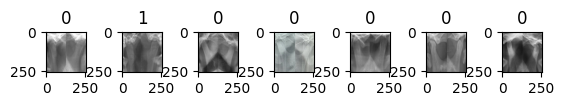

In [6]:
image,label = next(iter(train_loader))
print(image.shape,label.shape)
label = label.numpy()
for i in range(7):
    temp = i+1
    plt.subplot(1,7,temp)
    plt.imshow(convertimg(image[temp],3))
    plt.title(label[temp]) 
    plt.subplots_adjust(wspace=0.9, hspace=0.8)
plt.show()

In [7]:
import torch
from torch import nn
from torch.nn import functional as F

class FocalLoss(nn.Module):
    def __init__(self, alpha=None, gamma=2, num_classes=3, size_average=True):
        super(FocalLoss, self).__init__()
        self.size_average = size_average
        if alpha is None:
            self.alpha = torch.ones(num_classes)
        elif isinstance(alpha, list):
            assert len(alpha) == num_classes
            self.alpha = torch.Tensor(alpha)
        else:
            assert alpha < 1
            self.alpha = torch.zeros(num_classes)
            self.alpha[0] = alpha
            self.alpha[1:] = 1 - alpha

        self.gamma = gamma
        print('Focal Loss:')
        print('    Alpha = {}'.format(self.alpha))
        print('    Gamma = {}'.format(self.gamma))

    def forward(self, preds, labels):
        if preds.device != self.alpha.device:
            self.alpha = self.alpha.to(preds.device)

        # 使用log_softmax避免数值溢出
        log_probs = F.log_softmax(preds, dim=-1)
        probs = torch.exp(log_probs)
        
        # 选择标签对应的预测概率
        labels = labels.view(-1)
        probs = probs.gather(dim=1, index=labels.unsqueeze(1)).squeeze(1)
        log_probs = log_probs.gather(dim=1, index=labels.unsqueeze(1)).squeeze(1)
        alpha = self.alpha[labels]

        # 计算Focal Loss
        focal_weight = torch.pow(1 - probs, self.gamma)
        loss = -alpha * focal_weight * log_probs

        if self.size_average:
            return loss.mean()
        else:
            return loss.sum()

In [8]:
def adjust_learning_rate(optimizer, new_lr):
    for param_group in optimizer.param_groups:
        param_group['lr'] = new_lr
# 获取当前的学习率
def get_current_learning_rate(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

In [9]:
from tqdm import *
from torch.optim.lr_scheduler import StepLR
from torch import optim

def train_net(model, train_data, val_data, model_dir, batch=32, epochs=50, lr=1e-3):
    print("training the network...")
    #2、定义trainLoader 和 ValLoader
    train_loader  = DataLoader(train_data,batch_size=batch,shuffle=True)
    # 损失函数和优化器
    loss_func = nn.CrossEntropyLoss()
    # loss_func = FocalLoss(alpha=[0.75,0.25],num_classes=2)
    opt = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)
#     opt = optim.SGD(model.parameters(),lr=lr, momentum=0.9)
    train_size = len(train_loader)
    best_acc = 0
    model.train()
    # 开始训练
    for t in tqdm(range(epochs)):
        train_correct,train_loss = 0,0
        for inputs,outputs in train_loader:
            input_size = len(train_loader)
            inputs,outputs = inputs.to(device).float(),outputs.to(device).long()
            opt.zero_grad()
            pred = model(inputs)
            pred_classes = pred.argmax(dim=1)

            loss = loss_func(pred,outputs)
            # print(loss)
            # 反向传播
            loss.backward()
            opt.step()
#             # softmax激活为概率分布
#             pred = nn.functional.softmax(pred, dim=1)
            # 记录训练过程
            train_acc = ((pred_classes == outputs).type(torch.float).sum().item())/len(inputs)
            train_correct += train_acc
            train_loss += loss.cpu().float()
        # 获取当前学习率
        current_lr = get_current_learning_rate(opt)
        current_acc = train_correct / len(train_loader)
        current_loss = train_loss.item() / len(train_loader)
        print("epoch: {}/{}==== train_acc: {:<10.6f} train_loss: {:<10.6f} Current_lr: {:<10.6f}".format(
                    t, epochs, current_acc, current_loss, current_lr))
        # 更新学习率
        if ((t+1)%20==0) and (current_lr>0.00001):
            new_lr = current_lr*0.1  # 新的学习率
            adjust_learning_rate(opt, new_lr)
            print('Epoch:', t, 'NEW_LR:', new_lr)
        test_process(model,32,val_data, loss_func,best_acc,t)
         
        # # 保存权重
        # save_path = os.path.join('./',model_dir)
        # if not os.path.exists(save_path):
        #     os.makedirs(save_path)
        # if current_acc > best_acc:
        #     MODEL_PATH = os.path.join(model_dir, 'Model_epoch%{}_{}.pth'.format(t,current_acc))
        #     torch.save(model, MODEL_PATH)
        #     best_acc = current_acc

def test_process(model,batchsize,test_data, loss_Function,best_acc,t):
    # 1、初始化损失函数、优化器、学习率策略等
    model.eval()
    test_loader = DataLoader(test_data,batch_size=batchsize)
    TestAcc = []
    TestLoss = []
    with torch.no_grad():
        for inputs, outputs in test_loader:
            inputs, outputs = inputs.to(device).float(), outputs.to(device).long()
            # 计算损失
            pred = model(inputs)
            loss = loss_Function(pred,outputs)
            # softmax激活为概率分布
            pred = nn.functional.softmax(pred, dim=1)
            pred_classes = pred.argmax(dim=1)
            # 计算ACC
            train_acc = ((pred_classes == outputs).type(torch.float).sum().item())/ len(inputs)
            train_correct += train_acc
            train_loss += loss.cpu().float()
            # TestAcc.append(train_acc)
            # TestLoss.append(loss)
    
    avgTestLoss = torch.mean(torch.stack(TestLoss))
    avgTestAcc = sum(TestAcc) / len(TestAcc)
    print("testing loss is {:.5f},testing Acc is {:.5f}".format(avgTestLoss,avgTestAcc))

    # 保存权重
    save_path = os.path.join('./',model_dir)
    if not os.path.exists(save_path):
        os.makedirs(save_path)
    if avgTestAcc > best_acc:
        MODEL_PATH = os.path.join(model_dir, 'Model_epoch_{}_{}.pth'.format(t,avgTestAcc))
        torch.save(model, MODEL_PATH)
        best_acc = avgTestAcc

In [11]:
import torch
import torch.nn as nn
import torchvision.models as models

# 加载预训练的 VGG16 模型
# model = models.resnet101(pretrained=True)
model = models.resnet50(pretrained=True)


# 将模型移动到设备（GPU 或 CPU）
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


model.fc=nn.Linear(in_features=2048, out_features=2, bias=True)
model.to(device)

/home/boer/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/boer/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [12]:

transform = A.Compose([
    A.HorizontalFlip(p=0.5),  #水平翻转
    # A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0, rotate_limit=15, p=0.5),   # 平移、缩放和旋转
#     A.Sharpen(alpha=(0.2, 0.5), lightness=(0.5, 1.0), p=0.5),  # 锐化操作
#     A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2, p=0.5),    # 颜色抖动
#     A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2(),
])

tf = A.Compose([
    ToTensorV2(),
])
## 构建MyDataset实例
train_data = SmileDataset(data_dir=train_dir, transform=transform)
valid_data = SmileDataset(data_dir=valid_dir, transform=tf)
model_dir = 'vgg16_2'
batchSize = 32
score = train_net(model, train_data, valid_data, model_dir, batch=batchSize, epochs=200, lr=0.0001)

training the network...


  0%|                                                                                                                                                                              | 0/200 [00:00<?, ?it/s]

epoch: 0/200==== train_acc: 0.780769   train_loss: 0.482352   Current_lr: 0.000100  
testing loss is 0.83975,testing Acc is 0.61719


  0%|▊                                                                                                                                                                   | 1/200 [00:37<2:05:53, 37.96s/it]

epoch: 1/200==== train_acc: 0.766063   train_loss: 0.524169   Current_lr: 0.000100  
testing loss is 0.87083,testing Acc is 0.60938


  1%|█▋                                                                                                                                                                  | 2/200 [01:14<2:02:08, 37.01s/it]

epoch: 2/200==== train_acc: 0.765056   train_loss: 0.467403   Current_lr: 0.000100  
testing loss is 0.63851,testing Acc is 0.69922


  2%|██▍                                                                                                                                                                 | 3/200 [01:50<2:00:26, 36.68s/it]

epoch: 3/200==== train_acc: 0.808123   train_loss: 0.424700   Current_lr: 0.000100  
testing loss is 0.65246,testing Acc is 0.69531


  2%|███▎                                                                                                                                                                | 4/200 [02:26<1:59:21, 36.54s/it]

epoch: 4/200==== train_acc: 0.813682   train_loss: 0.413697   Current_lr: 0.000100  
testing loss is 0.60293,testing Acc is 0.69141


  2%|████                                                                                                                                                                | 5/200 [03:03<1:58:36, 36.49s/it]

epoch: 5/200==== train_acc: 0.825411   train_loss: 0.376120   Current_lr: 0.000100  
testing loss is 0.84396,testing Acc is 0.62891


  3%|████▉                                                                                                                                                               | 6/200 [03:39<1:57:48, 36.44s/it]

epoch: 6/200==== train_acc: 0.848389   train_loss: 0.351901   Current_lr: 0.000100  
testing loss is 0.74850,testing Acc is 0.70312


  4%|█████▋                                                                                                                                                              | 7/200 [04:16<1:57:07, 36.41s/it]

epoch: 7/200==== train_acc: 0.857581   train_loss: 0.331434   Current_lr: 0.000100  
testing loss is 0.59827,testing Acc is 0.71875


  4%|██████▌                                                                                                                                                             | 8/200 [04:52<1:56:23, 36.37s/it]

epoch: 8/200==== train_acc: 0.873775   train_loss: 0.285520   Current_lr: 0.000100  
testing loss is 0.89189,testing Acc is 0.69141


  4%|███████▍                                                                                                                                                            | 9/200 [05:28<1:55:59, 36.44s/it]

epoch: 9/200==== train_acc: 0.875832   train_loss: 0.280942   Current_lr: 0.000100  
testing loss is 1.03567,testing Acc is 0.70703


  5%|████████▏                                                                                                                                                          | 10/200 [06:05<1:55:10, 36.37s/it]

epoch: 10/200==== train_acc: 0.899816   train_loss: 0.228259   Current_lr: 0.000100  
testing loss is 1.19560,testing Acc is 0.73438


  6%|████████▉                                                                                                                                                          | 11/200 [06:41<1:54:26, 36.33s/it]

epoch: 11/200==== train_acc: 0.903274   train_loss: 0.229646   Current_lr: 0.000100  
testing loss is 1.46435,testing Acc is 0.65234


  6%|█████████▊                                                                                                                                                         | 12/200 [07:17<1:53:45, 36.31s/it]

epoch: 12/200==== train_acc: 0.903274   train_loss: 0.223364   Current_lr: 0.000100  
testing loss is 0.98348,testing Acc is 0.70312


  6%|██████████▌                                                                                                                                                        | 13/200 [07:54<1:53:28, 36.41s/it]

epoch: 13/200==== train_acc: 0.919424   train_loss: 0.198187   Current_lr: 0.000100  
testing loss is 0.85623,testing Acc is 0.72266


  7%|███████████▍                                                                                                                                                       | 14/200 [08:30<1:52:59, 36.45s/it]

epoch: 14/200==== train_acc: 0.919818   train_loss: 0.204809   Current_lr: 0.000100  
testing loss is 0.92259,testing Acc is 0.71094


  8%|████████████▏                                                                                                                                                      | 15/200 [09:07<1:52:12, 36.39s/it]

epoch: 15/200==== train_acc: 0.936187   train_loss: 0.167966   Current_lr: 0.000100  
testing loss is 0.93707,testing Acc is 0.70703


  8%|█████████████                                                                                                                                                      | 16/200 [09:43<1:51:59, 36.52s/it]

epoch: 16/200==== train_acc: 0.944196   train_loss: 0.158627   Current_lr: 0.000100  
testing loss is 1.02477,testing Acc is 0.73828


  8%|█████████████▊                                                                                                                                                     | 17/200 [10:20<1:51:20, 36.50s/it]

epoch: 17/200==== train_acc: 0.964461   train_loss: 0.110699   Current_lr: 0.000100  
testing loss is 1.85345,testing Acc is 0.69141


  9%|██████████████▋                                                                                                                                                    | 18/200 [10:56<1:50:52, 36.55s/it]

epoch: 18/200==== train_acc: 0.955357   train_loss: 0.117326   Current_lr: 0.000100  
testing loss is 1.61825,testing Acc is 0.69141


 10%|███████████████▍                                                                                                                                                   | 19/200 [11:33<1:50:22, 36.59s/it]

epoch: 19/200==== train_acc: 0.972733   train_loss: 0.080208   Current_lr: 0.000100  
Epoch: 19 NEW_LR: 1e-05
testing loss is 2.03024,testing Acc is 0.71875


 10%|████████████████▎                                                                                                                                                  | 20/200 [12:10<1:49:58, 36.66s/it]

epoch: 20/200==== train_acc: 0.983631   train_loss: 0.042182   Current_lr: 0.000010  
testing loss is 1.98756,testing Acc is 0.74609


 10%|█████████████████                                                                                                                                                  | 21/200 [12:46<1:49:05, 36.56s/it]

epoch: 21/200==== train_acc: 0.997024   train_loss: 0.019452   Current_lr: 0.000010  
testing loss is 2.10411,testing Acc is 0.74609


 11%|█████████████████▉                                                                                                                                                 | 22/200 [13:23<1:48:32, 36.58s/it]

epoch: 22/200==== train_acc: 0.996280   train_loss: 0.013954   Current_lr: 0.000010  
testing loss is 2.35325,testing Acc is 0.69922


 12%|██████████████████▋                                                                                                                                                | 23/200 [14:00<1:48:06, 36.64s/it]

epoch: 23/200==== train_acc: 0.997768   train_loss: 0.011977   Current_lr: 0.000010  
testing loss is 2.49985,testing Acc is 0.73438


 12%|███████████████████▌                                                                                                                                               | 24/200 [14:36<1:47:31, 36.66s/it]

epoch: 24/200==== train_acc: 0.997024   train_loss: 0.010344   Current_lr: 0.000010  
testing loss is 2.77047,testing Acc is 0.72656


 12%|████████████████████▍                                                                                                                                              | 25/200 [15:13<1:46:44, 36.60s/it]

epoch: 25/200==== train_acc: 0.997768   train_loss: 0.007050   Current_lr: 0.000010  
testing loss is 2.68817,testing Acc is 0.74219


 13%|█████████████████████▏                                                                                                                                             | 26/200 [15:49<1:45:58, 36.54s/it]

epoch: 26/200==== train_acc: 0.997024   train_loss: 0.007737   Current_lr: 0.000010  
testing loss is 2.66821,testing Acc is 0.71094


 14%|██████████████████████                                                                                                                                             | 27/200 [16:26<1:45:26, 36.57s/it]

epoch: 27/200==== train_acc: 0.998512   train_loss: 0.004233   Current_lr: 0.000010  
testing loss is 2.98466,testing Acc is 0.69141


 14%|██████████████████████▊                                                                                                                                            | 28/200 [17:02<1:44:48, 36.56s/it]

epoch: 28/200==== train_acc: 0.996280   train_loss: 0.005878   Current_lr: 0.000010  
testing loss is 2.87619,testing Acc is 0.71484


 14%|███████████████████████▋                                                                                                                                           | 29/200 [17:39<1:44:05, 36.52s/it]

epoch: 29/200==== train_acc: 0.997024   train_loss: 0.005337   Current_lr: 0.000010  
testing loss is 3.18277,testing Acc is 0.70312


 15%|████████████████████████▍                                                                                                                                          | 30/200 [18:15<1:43:31, 36.54s/it]

epoch: 30/200==== train_acc: 0.998512   train_loss: 0.005079   Current_lr: 0.000010  
testing loss is 3.23962,testing Acc is 0.71094


 16%|█████████████████████████▎                                                                                                                                         | 31/200 [18:52<1:42:59, 36.56s/it]

epoch: 31/200==== train_acc: 0.999256   train_loss: 0.003107   Current_lr: 0.000010  
testing loss is 3.17691,testing Acc is 0.74219


 16%|██████████████████████████                                                                                                                                         | 32/200 [19:29<1:42:23, 36.57s/it]

epoch: 32/200==== train_acc: 0.997024   train_loss: 0.005948   Current_lr: 0.000010  
testing loss is 3.41578,testing Acc is 0.69141


 16%|██████████████████████████▉                                                                                                                                        | 33/200 [20:05<1:41:50, 36.59s/it]

epoch: 33/200==== train_acc: 0.997768   train_loss: 0.007872   Current_lr: 0.000010  
testing loss is 2.96153,testing Acc is 0.70312


 17%|███████████████████████████▋                                                                                                                                       | 34/200 [20:42<1:41:20, 36.63s/it]

epoch: 34/200==== train_acc: 0.997768   train_loss: 0.004946   Current_lr: 0.000010  
testing loss is 2.84259,testing Acc is 0.69531


 18%|████████████████████████████▌                                                                                                                                      | 35/200 [21:19<1:40:43, 36.62s/it]

epoch: 35/200==== train_acc: 0.996280   train_loss: 0.005999   Current_lr: 0.000010  
testing loss is 3.41968,testing Acc is 0.73047


 18%|█████████████████████████████▎                                                                                                                                     | 36/200 [21:55<1:39:58, 36.57s/it]

epoch: 36/200==== train_acc: 0.996280   train_loss: 0.006628   Current_lr: 0.000010  
testing loss is 3.20514,testing Acc is 0.71484


 18%|██████████████████████████████▏                                                                                                                                    | 37/200 [22:32<1:39:21, 36.58s/it]

epoch: 37/200==== train_acc: 0.998512   train_loss: 0.004148   Current_lr: 0.000010  
testing loss is 3.21277,testing Acc is 0.66797


 19%|██████████████████████████████▉                                                                                                                                    | 38/200 [23:08<1:38:37, 36.53s/it]

epoch: 38/200==== train_acc: 0.998512   train_loss: 0.003123   Current_lr: 0.000010  
testing loss is 3.26380,testing Acc is 0.67578


 20%|███████████████████████████████▊                                                                                                                                   | 39/200 [23:45<1:37:55, 36.50s/it]

epoch: 39/200==== train_acc: 0.996280   train_loss: 0.005732   Current_lr: 0.000010  
testing loss is 3.41899,testing Acc is 0.69531


 20%|████████████████████████████████▌                                                                                                                                  | 40/200 [24:21<1:37:25, 36.53s/it]

epoch: 40/200==== train_acc: 0.997024   train_loss: 0.004732   Current_lr: 0.000010  
testing loss is 3.34315,testing Acc is 0.70312


 20%|█████████████████████████████████▍                                                                                                                                 | 41/200 [24:58<1:36:50, 36.55s/it]

epoch: 41/200==== train_acc: 0.997768   train_loss: 0.004168   Current_lr: 0.000010  
testing loss is 3.38855,testing Acc is 0.68359


 21%|██████████████████████████████████▏                                                                                                                                | 42/200 [25:34<1:36:05, 36.49s/it]

epoch: 42/200==== train_acc: 0.997768   train_loss: 0.004817   Current_lr: 0.000010  
testing loss is 3.28741,testing Acc is 0.70703


 22%|███████████████████████████████████                                                                                                                                | 43/200 [26:11<1:35:30, 36.50s/it]

epoch: 43/200==== train_acc: 0.998512   train_loss: 0.002905   Current_lr: 0.000010  
testing loss is 3.30679,testing Acc is 0.70703


 22%|███████████████████████████████████▊                                                                                                                               | 44/200 [26:47<1:34:57, 36.52s/it]

epoch: 44/200==== train_acc: 0.997768   train_loss: 0.004844   Current_lr: 0.000010  
testing loss is 3.21573,testing Acc is 0.67188


 22%|████████████████████████████████████▋                                                                                                                              | 45/200 [27:24<1:34:30, 36.58s/it]

epoch: 45/200==== train_acc: 0.996367   train_loss: 0.005628   Current_lr: 0.000010  
testing loss is 3.57643,testing Acc is 0.71484


 23%|█████████████████████████████████████▍                                                                                                                             | 46/200 [28:00<1:33:44, 36.52s/it]

epoch: 46/200==== train_acc: 0.997024   train_loss: 0.006352   Current_lr: 0.000010  
testing loss is 3.19190,testing Acc is 0.71875


 24%|██████████████████████████████████████▎                                                                                                                            | 47/200 [28:37<1:32:59, 36.47s/it]

epoch: 47/200==== train_acc: 0.997111   train_loss: 0.004294   Current_lr: 0.000010  
testing loss is 3.44447,testing Acc is 0.70703


 24%|███████████████████████████████████████                                                                                                                            | 48/200 [29:13<1:32:18, 36.44s/it]

epoch: 48/200==== train_acc: 0.999256   train_loss: 0.002836   Current_lr: 0.000010  
testing loss is 3.54030,testing Acc is 0.67578


 24%|███████████████████████████████████████▉                                                                                                                           | 49/200 [29:49<1:31:35, 36.39s/it]

epoch: 49/200==== train_acc: 0.997024   train_loss: 0.006108   Current_lr: 0.000010  
testing loss is 3.55070,testing Acc is 0.73828


 25%|████████████████████████████████████████▊                                                                                                                          | 50/200 [30:26<1:30:55, 36.37s/it]

epoch: 50/200==== train_acc: 0.997768   train_loss: 0.003547   Current_lr: 0.000010  
testing loss is 2.90044,testing Acc is 0.66797


 26%|█████████████████████████████████████████▌                                                                                                                         | 51/200 [31:02<1:30:13, 36.33s/it]

epoch: 51/200==== train_acc: 0.998512   train_loss: 0.002989   Current_lr: 0.000010  
testing loss is 3.32714,testing Acc is 0.69922


 26%|██████████████████████████████████████████▍                                                                                                                        | 52/200 [31:38<1:29:37, 36.34s/it]

epoch: 52/200==== train_acc: 0.998512   train_loss: 0.002820   Current_lr: 0.000010  
testing loss is 3.34042,testing Acc is 0.68359


 26%|███████████████████████████████████████████▏                                                                                                                       | 53/200 [32:15<1:29:03, 36.35s/it]

epoch: 53/200==== train_acc: 0.998512   train_loss: 0.002461   Current_lr: 0.000010  
testing loss is 3.37844,testing Acc is 0.71484


 27%|████████████████████████████████████████████                                                                                                                       | 54/200 [32:51<1:28:28, 36.36s/it]

epoch: 54/200==== train_acc: 0.999256   train_loss: 0.002487   Current_lr: 0.000010  
testing loss is 3.95144,testing Acc is 0.69531


 28%|████████████████████████████████████████████▊                                                                                                                      | 55/200 [33:27<1:27:51, 36.36s/it]

epoch: 55/200==== train_acc: 0.999256   train_loss: 0.002060   Current_lr: 0.000010  
testing loss is 3.68066,testing Acc is 0.69531


 28%|█████████████████████████████████████████████▋                                                                                                                     | 56/200 [34:04<1:27:14, 36.35s/it]

epoch: 56/200==== train_acc: 0.998512   train_loss: 0.002795   Current_lr: 0.000010  
testing loss is 3.73934,testing Acc is 0.69922


 28%|██████████████████████████████████████████████▍                                                                                                                    | 57/200 [34:40<1:26:36, 36.34s/it]

epoch: 57/200==== train_acc: 0.998512   train_loss: 0.004654   Current_lr: 0.000010  
testing loss is 3.15478,testing Acc is 0.68359


 29%|███████████████████████████████████████████████▎                                                                                                                   | 58/200 [35:16<1:25:58, 36.33s/it]

epoch: 58/200==== train_acc: 0.997768   train_loss: 0.006871   Current_lr: 0.000010  
testing loss is 3.35101,testing Acc is 0.73047


 30%|████████████████████████████████████████████████                                                                                                                   | 59/200 [35:53<1:25:24, 36.34s/it]

epoch: 59/200==== train_acc: 0.999256   train_loss: 0.002860   Current_lr: 0.000010  
testing loss is 3.50676,testing Acc is 0.70703


 30%|████████████████████████████████████████████████▉                                                                                                                  | 60/200 [36:29<1:24:48, 36.35s/it]

epoch: 60/200==== train_acc: 0.997768   train_loss: 0.004134   Current_lr: 0.000010  
testing loss is 3.41997,testing Acc is 0.66016


 30%|█████████████████████████████████████████████████▋                                                                                                                 | 61/200 [37:05<1:24:02, 36.28s/it]

epoch: 61/200==== train_acc: 0.997768   train_loss: 0.004524   Current_lr: 0.000010  
testing loss is 3.16060,testing Acc is 0.67188


 31%|██████████████████████████████████████████████████▌                                                                                                                | 62/200 [37:41<1:23:27, 36.29s/it]

epoch: 62/200==== train_acc: 0.997768   train_loss: 0.002676   Current_lr: 0.000010  
testing loss is 3.29862,testing Acc is 0.69141


 32%|███████████████████████████████████████████████████▎                                                                                                               | 63/200 [38:18<1:22:54, 36.31s/it]

epoch: 63/200==== train_acc: 0.997768   train_loss: 0.004317   Current_lr: 0.000010  
testing loss is 3.41341,testing Acc is 0.67969


 32%|████████████████████████████████████████████████████▏                                                                                                              | 64/200 [38:54<1:22:11, 36.26s/it]

epoch: 64/200==== train_acc: 0.998512   train_loss: 0.002917   Current_lr: 0.000010  
testing loss is 3.44206,testing Acc is 0.70703


 32%|████████████████████████████████████████████████████▉                                                                                                              | 65/200 [39:30<1:21:37, 36.27s/it]

epoch: 65/200==== train_acc: 1.000000   train_loss: 0.001824   Current_lr: 0.000010  
testing loss is 3.51121,testing Acc is 0.69531


 33%|█████████████████████████████████████████████████████▊                                                                                                             | 66/200 [40:07<1:21:05, 36.31s/it]

epoch: 66/200==== train_acc: 0.998512   train_loss: 0.003160   Current_lr: 0.000010  
testing loss is 3.76538,testing Acc is 0.73438


 34%|██████████████████████████████████████████████████████▌                                                                                                            | 67/200 [40:43<1:20:31, 36.33s/it]

epoch: 67/200==== train_acc: 0.998512   train_loss: 0.003202   Current_lr: 0.000010  
testing loss is 3.78203,testing Acc is 0.67188


 34%|███████████████████████████████████████████████████████▍                                                                                                           | 68/200 [41:19<1:19:58, 36.36s/it]

epoch: 68/200==== train_acc: 0.997024   train_loss: 0.005635   Current_lr: 0.000010  
testing loss is 3.22472,testing Acc is 0.71094


 34%|████████████████████████████████████████████████████████▏                                                                                                          | 69/200 [41:56<1:19:24, 36.37s/it]

epoch: 69/200==== train_acc: 0.998512   train_loss: 0.002842   Current_lr: 0.000010  
testing loss is 3.59400,testing Acc is 0.69531


 35%|█████████████████████████████████████████████████████████                                                                                                          | 70/200 [42:32<1:18:46, 36.36s/it]

epoch: 70/200==== train_acc: 0.997768   train_loss: 0.003957   Current_lr: 0.000010  
testing loss is 3.30929,testing Acc is 0.67578


 36%|█████████████████████████████████████████████████████████▊                                                                                                         | 71/200 [43:09<1:18:13, 36.38s/it]

epoch: 71/200==== train_acc: 0.997024   train_loss: 0.004324   Current_lr: 0.000010  
testing loss is 3.69537,testing Acc is 0.70312


 36%|██████████████████████████████████████████████████████████▋                                                                                                        | 72/200 [43:45<1:17:35, 36.37s/it]

epoch: 72/200==== train_acc: 0.999256   train_loss: 0.003154   Current_lr: 0.000010  
testing loss is 3.82600,testing Acc is 0.70312


 36%|███████████████████████████████████████████████████████████▍                                                                                                       | 73/200 [44:21<1:17:01, 36.39s/it]

epoch: 73/200==== train_acc: 0.997111   train_loss: 0.003856   Current_lr: 0.000010  
testing loss is 3.72177,testing Acc is 0.66406


 37%|████████████████████████████████████████████████████████████▎                                                                                                      | 74/200 [44:58<1:16:15, 36.32s/it]

epoch: 74/200==== train_acc: 0.997024   train_loss: 0.009725   Current_lr: 0.000010  
testing loss is 3.15280,testing Acc is 0.69922


 38%|█████████████████████████████████████████████████████████████▏                                                                                                     | 75/200 [45:34<1:15:40, 36.32s/it]

epoch: 75/200==== train_acc: 0.996280   train_loss: 0.010460   Current_lr: 0.000010  
testing loss is 3.20511,testing Acc is 0.69922


 38%|█████████████████████████████████████████████████████████████▉                                                                                                     | 76/200 [46:10<1:15:06, 36.34s/it]

epoch: 76/200==== train_acc: 0.997024   train_loss: 0.003751   Current_lr: 0.000010  
testing loss is 3.19674,testing Acc is 0.66406


 38%|██████████████████████████████████████████████████████████████▊                                                                                                    | 77/200 [46:47<1:14:30, 36.34s/it]

epoch: 77/200==== train_acc: 0.997024   train_loss: 0.003530   Current_lr: 0.000010  
testing loss is 3.48745,testing Acc is 0.66406


 39%|███████████████████████████████████████████████████████████████▌                                                                                                   | 78/200 [47:23<1:13:56, 36.37s/it]

epoch: 78/200==== train_acc: 0.997768   train_loss: 0.004231   Current_lr: 0.000010  
testing loss is 3.27588,testing Acc is 0.67188


 40%|████████████████████████████████████████████████████████████████▍                                                                                                  | 79/200 [47:59<1:13:23, 36.39s/it]

epoch: 79/200==== train_acc: 0.997768   train_loss: 0.003318   Current_lr: 0.000010  
testing loss is 3.13409,testing Acc is 0.69922


 40%|█████████████████████████████████████████████████████████████████▏                                                                                                 | 80/200 [48:36<1:12:49, 36.41s/it]

epoch: 80/200==== train_acc: 0.998512   train_loss: 0.003354   Current_lr: 0.000010  
testing loss is 3.52371,testing Acc is 0.71094


 40%|██████████████████████████████████████████████████████████████████                                                                                                 | 81/200 [49:12<1:12:11, 36.40s/it]

epoch: 81/200==== train_acc: 0.997768   train_loss: 0.003433   Current_lr: 0.000010  
testing loss is 3.37992,testing Acc is 0.69922


 41%|██████████████████████████████████████████████████████████████████▊                                                                                                | 82/200 [49:49<1:11:35, 36.40s/it]

epoch: 82/200==== train_acc: 0.998512   train_loss: 0.002489   Current_lr: 0.000010  
testing loss is 3.54192,testing Acc is 0.67969


 42%|███████████████████████████████████████████████████████████████████▋                                                                                               | 83/200 [50:25<1:10:57, 36.39s/it]

epoch: 83/200==== train_acc: 0.999256   train_loss: 0.002088   Current_lr: 0.000010  
testing loss is 3.69751,testing Acc is 0.69531


 42%|████████████████████████████████████████████████████████████████████▍                                                                                              | 84/200 [51:01<1:10:20, 36.39s/it]

epoch: 84/200==== train_acc: 0.997768   train_loss: 0.003192   Current_lr: 0.000010  
testing loss is 3.68311,testing Acc is 0.70312


 42%|█████████████████████████████████████████████████████████████████████▎                                                                                             | 85/200 [51:38<1:09:44, 36.38s/it]

epoch: 85/200==== train_acc: 0.999256   train_loss: 0.002533   Current_lr: 0.000010  
testing loss is 3.59118,testing Acc is 0.70312


 43%|██████████████████████████████████████████████████████████████████████                                                                                             | 86/200 [52:14<1:09:07, 36.38s/it]

epoch: 86/200==== train_acc: 0.997024   train_loss: 0.004115   Current_lr: 0.000010  
testing loss is 3.76056,testing Acc is 0.69531


 44%|██████████████████████████████████████████████████████████████████████▉                                                                                            | 87/200 [52:51<1:08:31, 36.38s/it]

epoch: 87/200==== train_acc: 0.998512   train_loss: 0.003498   Current_lr: 0.000010  
testing loss is 3.42812,testing Acc is 0.70312


 44%|███████████████████████████████████████████████████████████████████████▋                                                                                           | 88/200 [53:27<1:07:53, 36.37s/it]

epoch: 88/200==== train_acc: 0.997768   train_loss: 0.002604   Current_lr: 0.000010  
testing loss is 3.32102,testing Acc is 0.71484


 44%|████████████████████████████████████████████████████████████████████████▌                                                                                          | 89/200 [54:03<1:07:18, 36.38s/it]

epoch: 89/200==== train_acc: 0.999256   train_loss: 0.001925   Current_lr: 0.000010  
testing loss is 3.49184,testing Acc is 0.69531


 45%|█████████████████████████████████████████████████████████████████████████▎                                                                                         | 90/200 [54:40<1:06:41, 36.38s/it]

epoch: 90/200==== train_acc: 0.997024   train_loss: 0.004605   Current_lr: 0.000010  
testing loss is 3.40016,testing Acc is 0.67578


 46%|██████████████████████████████████████████████████████████████████████████▏                                                                                        | 91/200 [55:16<1:06:05, 36.38s/it]

epoch: 91/200==== train_acc: 0.997768   train_loss: 0.002607   Current_lr: 0.000010  
testing loss is 3.27691,testing Acc is 0.70703


 46%|██████████████████████████████████████████████████████████████████████████▉                                                                                        | 92/200 [55:52<1:05:28, 36.37s/it]

epoch: 92/200==== train_acc: 0.997024   train_loss: 0.003400   Current_lr: 0.000010  
testing loss is 3.43867,testing Acc is 0.67578


 46%|███████████████████████████████████████████████████████████████████████████▊                                                                                       | 93/200 [56:29<1:04:51, 36.37s/it]

epoch: 93/200==== train_acc: 0.997768   train_loss: 0.002648   Current_lr: 0.000010  
testing loss is 3.51645,testing Acc is 0.70312


 47%|████████████████████████████████████████████████████████████████████████████▌                                                                                      | 94/200 [57:05<1:04:17, 36.39s/it]

epoch: 94/200==== train_acc: 0.997024   train_loss: 0.002784   Current_lr: 0.000010  
testing loss is 3.35230,testing Acc is 0.67578


 48%|█████████████████████████████████████████████████████████████████████████████▍                                                                                     | 95/200 [57:42<1:03:40, 36.39s/it]

epoch: 95/200==== train_acc: 0.997768   train_loss: 0.002884   Current_lr: 0.000010  
testing loss is 3.54749,testing Acc is 0.69531


 48%|██████████████████████████████████████████████████████████████████████████████▏                                                                                    | 96/200 [58:18<1:03:04, 36.39s/it]

epoch: 96/200==== train_acc: 0.998512   train_loss: 0.002770   Current_lr: 0.000010  
testing loss is 3.24742,testing Acc is 0.70312


 48%|███████████████████████████████████████████████████████████████████████████████                                                                                    | 97/200 [58:54<1:02:29, 36.40s/it]

epoch: 97/200==== train_acc: 0.998512   train_loss: 0.002417   Current_lr: 0.000010  
testing loss is 3.54728,testing Acc is 0.66797


 49%|███████████████████████████████████████████████████████████████████████████████▊                                                                                   | 98/200 [59:31<1:01:51, 36.39s/it]

epoch: 98/200==== train_acc: 0.998512   train_loss: 0.002789   Current_lr: 0.000010  
testing loss is 3.67420,testing Acc is 0.69141


 50%|███████████████████████████████████████████████████████████████████████████████▋                                                                                 | 99/200 [1:00:07<1:01:15, 36.39s/it]

epoch: 99/200==== train_acc: 0.997024   train_loss: 0.003400   Current_lr: 0.000010  
testing loss is 3.54467,testing Acc is 0.71875


 50%|████████████████████████████████████████████████████████████████████████████████                                                                                | 100/200 [1:00:44<1:00:39, 36.39s/it]

epoch: 100/200==== train_acc: 0.997768   train_loss: 0.003615   Current_lr: 0.000010  
testing loss is 3.57974,testing Acc is 0.67578


 50%|████████████████████████████████████████████████████████████████████████████████▊                                                                               | 101/200 [1:01:20<1:00:01, 36.38s/it]

epoch: 101/200==== train_acc: 0.997768   train_loss: 0.003716   Current_lr: 0.000010  
testing loss is 3.85176,testing Acc is 0.71094


 51%|██████████████████████████████████████████████████████████████████████████████████▌                                                                               | 102/200 [1:01:56<59:24, 36.37s/it]

epoch: 102/200==== train_acc: 0.997768   train_loss: 0.003015   Current_lr: 0.000010  
testing loss is 3.63770,testing Acc is 0.70312


 52%|███████████████████████████████████████████████████████████████████████████████████▍                                                                              | 103/200 [1:02:33<58:48, 36.38s/it]

epoch: 103/200==== train_acc: 0.997768   train_loss: 0.003301   Current_lr: 0.000010  
testing loss is 3.69532,testing Acc is 0.67578


 52%|████████████████████████████████████████████████████████████████████████████████████▏                                                                             | 104/200 [1:03:09<58:13, 36.39s/it]

epoch: 104/200==== train_acc: 0.998512   train_loss: 0.002822   Current_lr: 0.000010  
testing loss is 3.82625,testing Acc is 0.67969


 52%|█████████████████████████████████████████████████████████████████████████████████████                                                                             | 105/200 [1:03:45<57:36, 36.38s/it]

epoch: 105/200==== train_acc: 0.997024   train_loss: 0.003039   Current_lr: 0.000010  
testing loss is 3.77486,testing Acc is 0.68750


 53%|█████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 106/200 [1:04:22<56:52, 36.31s/it]

epoch: 106/200==== train_acc: 0.997768   train_loss: 0.003277   Current_lr: 0.000010  
testing loss is 3.82433,testing Acc is 0.70703


 54%|██████████████████████████████████████████████████████████████████████████████████████▋                                                                           | 107/200 [1:04:58<56:18, 36.33s/it]

epoch: 107/200==== train_acc: 0.998512   train_loss: 0.003041   Current_lr: 0.000010  
testing loss is 3.57999,testing Acc is 0.69531


 54%|███████████████████████████████████████████████████████████████████████████████████████▍                                                                          | 108/200 [1:05:34<55:40, 36.31s/it]

epoch: 108/200==== train_acc: 0.997768   train_loss: 0.002384   Current_lr: 0.000010  
testing loss is 3.66095,testing Acc is 0.69922


 55%|████████████████████████████████████████████████████████████████████████████████████████▎                                                                         | 109/200 [1:06:11<55:05, 36.32s/it]

epoch: 109/200==== train_acc: 0.997024   train_loss: 0.004169   Current_lr: 0.000010  
testing loss is 3.51932,testing Acc is 0.71094


 55%|█████████████████████████████████████████████████████████████████████████████████████████                                                                         | 110/200 [1:06:47<54:29, 36.32s/it]

epoch: 110/200==== train_acc: 0.998512   train_loss: 0.002396   Current_lr: 0.000010  
testing loss is 3.37762,testing Acc is 0.70312


 56%|█████████████████████████████████████████████████████████████████████████████████████████▉                                                                        | 111/200 [1:07:23<53:55, 36.35s/it]

epoch: 111/200==== train_acc: 0.998512   train_loss: 0.002642   Current_lr: 0.000010  
testing loss is 3.59752,testing Acc is 0.66797


 56%|██████████████████████████████████████████████████████████████████████████████████████████▋                                                                       | 112/200 [1:08:00<53:20, 36.37s/it]

epoch: 112/200==== train_acc: 0.997768   train_loss: 0.002525   Current_lr: 0.000010  
testing loss is 3.75699,testing Acc is 0.66797


 56%|███████████████████████████████████████████████████████████████████████████████████████████▌                                                                      | 113/200 [1:08:36<52:45, 36.38s/it]

epoch: 113/200==== train_acc: 0.998599   train_loss: 0.003149   Current_lr: 0.000010  
testing loss is 3.71471,testing Acc is 0.69531


 57%|████████████████████████████████████████████████████████████████████████████████████████████▎                                                                     | 114/200 [1:09:13<52:09, 36.38s/it]

epoch: 114/200==== train_acc: 0.999256   train_loss: 0.001577   Current_lr: 0.000010  
testing loss is 3.64369,testing Acc is 0.67188


 57%|█████████████████████████████████████████████████████████████████████████████████████████████▏                                                                    | 115/200 [1:09:49<51:32, 36.39s/it]

epoch: 115/200==== train_acc: 0.997768   train_loss: 0.005107   Current_lr: 0.000010  
testing loss is 3.96164,testing Acc is 0.68750


 58%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                                                    | 116/200 [1:10:25<51:00, 36.43s/it]

epoch: 116/200==== train_acc: 0.995711   train_loss: 0.004765   Current_lr: 0.000010  
testing loss is 3.36564,testing Acc is 0.70312


 58%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                                                   | 117/200 [1:11:02<50:21, 36.41s/it]

epoch: 117/200==== train_acc: 0.998512   train_loss: 0.002075   Current_lr: 0.000010  
testing loss is 3.67906,testing Acc is 0.66797


 59%|███████████████████████████████████████████████████████████████████████████████████████████████▌                                                                  | 118/200 [1:11:38<49:45, 36.41s/it]

epoch: 118/200==== train_acc: 0.998512   train_loss: 0.003143   Current_lr: 0.000010  
testing loss is 3.56183,testing Acc is 0.66797


 60%|████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                 | 119/200 [1:12:15<49:08, 36.40s/it]

epoch: 119/200==== train_acc: 0.997768   train_loss: 0.002559   Current_lr: 0.000010  
testing loss is 3.71172,testing Acc is 0.69531


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                | 120/200 [1:12:51<48:31, 36.39s/it]

epoch: 120/200==== train_acc: 0.999256   train_loss: 0.002874   Current_lr: 0.000010  
testing loss is 3.55489,testing Acc is 0.69531


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████                                                                | 121/200 [1:13:27<47:54, 36.38s/it]

epoch: 121/200==== train_acc: 0.997855   train_loss: 0.003656   Current_lr: 0.000010  
testing loss is 3.38139,testing Acc is 0.71094


 61%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                                                               | 122/200 [1:14:04<47:16, 36.37s/it]

epoch: 122/200==== train_acc: 0.997768   train_loss: 0.003200   Current_lr: 0.000010  
testing loss is 3.54270,testing Acc is 0.67578


 62%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                                                              | 123/200 [1:14:40<46:39, 36.36s/it]

epoch: 123/200==== train_acc: 0.999256   train_loss: 0.001963   Current_lr: 0.000010  
testing loss is 3.89682,testing Acc is 0.67188


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                             | 124/200 [1:15:16<46:02, 36.35s/it]

epoch: 124/200==== train_acc: 0.997768   train_loss: 0.003304   Current_lr: 0.000010  
testing loss is 4.00403,testing Acc is 0.68359


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                            | 125/200 [1:15:53<45:27, 36.37s/it]

epoch: 125/200==== train_acc: 0.997768   train_loss: 0.002515   Current_lr: 0.000010  
testing loss is 3.80688,testing Acc is 0.67578


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                                            | 126/200 [1:16:29<44:51, 36.37s/it]

epoch: 126/200==== train_acc: 0.997024   train_loss: 0.002917   Current_lr: 0.000010  
testing loss is 3.42516,testing Acc is 0.67188


 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                           | 127/200 [1:17:05<44:13, 36.35s/it]

epoch: 127/200==== train_acc: 0.999256   train_loss: 0.001716   Current_lr: 0.000010  
testing loss is 3.80370,testing Acc is 0.69922


 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                          | 128/200 [1:17:42<43:37, 36.36s/it]

epoch: 128/200==== train_acc: 0.999256   train_loss: 0.001584   Current_lr: 0.000010  
testing loss is 3.79909,testing Acc is 0.70703


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                         | 129/200 [1:18:18<43:02, 36.38s/it]

epoch: 129/200==== train_acc: 0.998512   train_loss: 0.002908   Current_lr: 0.000010  
testing loss is 3.52810,testing Acc is 0.71094


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                        | 130/200 [1:18:55<42:26, 36.38s/it]

epoch: 130/200==== train_acc: 0.998512   train_loss: 0.002407   Current_lr: 0.000010  
testing loss is 3.79197,testing Acc is 0.69531


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                                                        | 131/200 [1:19:31<41:50, 36.38s/it]

epoch: 131/200==== train_acc: 0.997768   train_loss: 0.001833   Current_lr: 0.000010  
testing loss is 3.92477,testing Acc is 0.69922


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                       | 132/200 [1:20:07<41:12, 36.37s/it]

epoch: 132/200==== train_acc: 0.997768   train_loss: 0.004161   Current_lr: 0.000010  
testing loss is 3.90753,testing Acc is 0.69922


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                      | 133/200 [1:20:44<40:36, 36.37s/it]

epoch: 133/200==== train_acc: 0.997111   train_loss: 0.003530   Current_lr: 0.000010  
testing loss is 3.71056,testing Acc is 0.69141


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                     | 134/200 [1:21:20<40:00, 36.38s/it]

epoch: 134/200==== train_acc: 0.997024   train_loss: 0.002676   Current_lr: 0.000010  
testing loss is 3.74958,testing Acc is 0.67969


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                    | 135/200 [1:21:56<39:23, 36.37s/it]

epoch: 135/200==== train_acc: 0.997768   train_loss: 0.002756   Current_lr: 0.000010  
testing loss is 3.72847,testing Acc is 0.67188


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                   | 136/200 [1:22:33<38:47, 36.36s/it]

epoch: 136/200==== train_acc: 0.998512   train_loss: 0.002383   Current_lr: 0.000010  
testing loss is 3.38528,testing Acc is 0.68359


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                   | 137/200 [1:23:09<38:11, 36.37s/it]

epoch: 137/200==== train_acc: 0.998512   train_loss: 0.002716   Current_lr: 0.000010  
testing loss is 3.78626,testing Acc is 0.70312


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                  | 138/200 [1:23:46<37:34, 36.37s/it]

epoch: 138/200==== train_acc: 0.997768   train_loss: 0.003148   Current_lr: 0.000010  
testing loss is 3.26472,testing Acc is 0.67969


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                 | 139/200 [1:24:22<36:59, 36.38s/it]

epoch: 139/200==== train_acc: 0.998512   train_loss: 0.002243   Current_lr: 0.000010  
testing loss is 3.97941,testing Acc is 0.67188


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                | 140/200 [1:24:58<36:22, 36.37s/it]

epoch: 140/200==== train_acc: 0.997768   train_loss: 0.003163   Current_lr: 0.000010  
testing loss is 3.63318,testing Acc is 0.67188


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                               | 141/200 [1:25:35<35:45, 36.36s/it]

epoch: 141/200==== train_acc: 0.998512   train_loss: 0.002946   Current_lr: 0.000010  
testing loss is 3.60615,testing Acc is 0.69922


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                               | 142/200 [1:26:11<35:08, 36.36s/it]

epoch: 142/200==== train_acc: 0.999256   train_loss: 0.001901   Current_lr: 0.000010  
testing loss is 3.91830,testing Acc is 0.69922


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                              | 143/200 [1:26:47<34:31, 36.34s/it]

epoch: 143/200==== train_acc: 0.998512   train_loss: 0.002218   Current_lr: 0.000010  
testing loss is 3.89754,testing Acc is 0.69141


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                             | 144/200 [1:27:24<33:55, 36.35s/it]

epoch: 144/200==== train_acc: 0.998512   train_loss: 0.002913   Current_lr: 0.000010  
testing loss is 3.57193,testing Acc is 0.66797


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                            | 145/200 [1:28:00<33:20, 36.37s/it]

epoch: 145/200==== train_acc: 0.997768   train_loss: 0.003658   Current_lr: 0.000010  
testing loss is 3.69575,testing Acc is 0.66797


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                           | 146/200 [1:28:36<32:43, 36.36s/it]

epoch: 146/200==== train_acc: 0.997768   train_loss: 0.002438   Current_lr: 0.000010  
testing loss is 3.54611,testing Acc is 0.69922


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                           | 147/200 [1:29:13<32:07, 36.37s/it]

epoch: 147/200==== train_acc: 0.997111   train_loss: 0.003942   Current_lr: 0.000010  
testing loss is 3.35548,testing Acc is 0.70703


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                          | 148/200 [1:29:49<31:31, 36.38s/it]

epoch: 148/200==== train_acc: 0.997024   train_loss: 0.002966   Current_lr: 0.000010  
testing loss is 3.74092,testing Acc is 0.70703


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                         | 149/200 [1:30:26<30:55, 36.38s/it]

epoch: 149/200==== train_acc: 1.000000   train_loss: 0.001614   Current_lr: 0.000010  
testing loss is 3.66618,testing Acc is 0.69531


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                        | 150/200 [1:31:02<30:19, 36.38s/it]

epoch: 150/200==== train_acc: 0.999256   train_loss: 0.001723   Current_lr: 0.000010  
testing loss is 3.76648,testing Acc is 0.69922


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 151/200 [1:31:38<29:42, 36.38s/it]

epoch: 151/200==== train_acc: 0.998512   train_loss: 0.003228   Current_lr: 0.000010  
testing loss is 3.30237,testing Acc is 0.67578


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                       | 152/200 [1:32:15<29:05, 36.37s/it]

epoch: 152/200==== train_acc: 0.997024   train_loss: 0.004406   Current_lr: 0.000010  
testing loss is 3.71990,testing Acc is 0.69922


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                      | 153/200 [1:32:51<28:29, 36.37s/it]

epoch: 153/200==== train_acc: 0.997768   train_loss: 0.003198   Current_lr: 0.000010  
testing loss is 2.96229,testing Acc is 0.66797


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                     | 154/200 [1:33:27<27:53, 36.38s/it]

epoch: 154/200==== train_acc: 0.998512   train_loss: 0.001983   Current_lr: 0.000010  
testing loss is 3.43060,testing Acc is 0.67188


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 155/200 [1:34:04<27:16, 36.37s/it]

epoch: 155/200==== train_acc: 0.999256   train_loss: 0.002274   Current_lr: 0.000010  
testing loss is 3.52584,testing Acc is 0.70703


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                   | 156/200 [1:34:40<26:40, 36.37s/it]

epoch: 156/200==== train_acc: 0.999256   train_loss: 0.001648   Current_lr: 0.000010  
testing loss is 3.51843,testing Acc is 0.71094


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 157/200 [1:35:17<26:04, 36.37s/it]

epoch: 157/200==== train_acc: 0.998512   train_loss: 0.001688   Current_lr: 0.000010  
testing loss is 3.79695,testing Acc is 0.71094


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                  | 158/200 [1:35:53<25:27, 36.37s/it]

epoch: 158/200==== train_acc: 0.997024   train_loss: 0.005854   Current_lr: 0.000010  
testing loss is 3.04000,testing Acc is 0.70703


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                 | 159/200 [1:36:29<24:49, 36.34s/it]

epoch: 159/200==== train_acc: 0.998512   train_loss: 0.002953   Current_lr: 0.000010  
testing loss is 3.75780,testing Acc is 0.67969


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                | 160/200 [1:37:06<24:13, 36.35s/it]

epoch: 160/200==== train_acc: 0.997768   train_loss: 0.002639   Current_lr: 0.000010  
testing loss is 3.66878,testing Acc is 0.68750


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                               | 161/200 [1:37:42<23:37, 36.35s/it]

epoch: 161/200==== train_acc: 0.999256   train_loss: 0.002186   Current_lr: 0.000010  
testing loss is 3.80652,testing Acc is 0.66797


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                              | 162/200 [1:38:18<23:01, 36.37s/it]

epoch: 162/200==== train_acc: 0.997855   train_loss: 0.005544   Current_lr: 0.000010  
testing loss is 3.97761,testing Acc is 0.69922


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                              | 163/200 [1:38:55<22:25, 36.36s/it]

epoch: 163/200==== train_acc: 0.995536   train_loss: 0.014821   Current_lr: 0.000010  
testing loss is 2.33296,testing Acc is 0.71484


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                             | 164/200 [1:39:31<21:49, 36.37s/it]

epoch: 164/200==== train_acc: 0.994135   train_loss: 0.014300   Current_lr: 0.000010  
testing loss is 3.76827,testing Acc is 0.72266


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                            | 165/200 [1:40:07<21:12, 36.36s/it]

epoch: 165/200==== train_acc: 0.988839   train_loss: 0.036009   Current_lr: 0.000010  
testing loss is 3.27254,testing Acc is 0.71094


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 166/200 [1:40:44<20:35, 36.35s/it]

epoch: 166/200==== train_acc: 0.996280   train_loss: 0.011952   Current_lr: 0.000010  
testing loss is 2.36564,testing Acc is 0.69531


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 167/200 [1:41:20<19:59, 36.36s/it]

epoch: 167/200==== train_acc: 0.997024   train_loss: 0.004506   Current_lr: 0.000010  
testing loss is 3.05014,testing Acc is 0.69922


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                          | 168/200 [1:41:57<19:23, 36.37s/it]

epoch: 168/200==== train_acc: 0.997768   train_loss: 0.003082   Current_lr: 0.000010  
testing loss is 3.11536,testing Acc is 0.71875


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                         | 169/200 [1:42:33<18:47, 36.36s/it]

epoch: 169/200==== train_acc: 0.997768   train_loss: 0.003439   Current_lr: 0.000010  
testing loss is 3.06125,testing Acc is 0.66016


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 170/200 [1:43:09<18:12, 36.42s/it]

epoch: 170/200==== train_acc: 0.999256   train_loss: 0.002456   Current_lr: 0.000010  
testing loss is 3.22374,testing Acc is 0.74219


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 171/200 [1:43:46<17:35, 36.39s/it]

epoch: 171/200==== train_acc: 0.997768   train_loss: 0.003030   Current_lr: 0.000010  
testing loss is 3.32968,testing Acc is 0.70312


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                      | 172/200 [1:44:22<16:58, 36.37s/it]

epoch: 172/200==== train_acc: 0.997024   train_loss: 0.002446   Current_lr: 0.000010  
testing loss is 3.43299,testing Acc is 0.71484


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 173/200 [1:44:58<16:21, 36.35s/it]

epoch: 173/200==== train_acc: 0.997768   train_loss: 0.002994   Current_lr: 0.000010  
testing loss is 3.49275,testing Acc is 0.70312


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                     | 174/200 [1:45:35<15:45, 36.35s/it]

epoch: 174/200==== train_acc: 0.999256   train_loss: 0.002010   Current_lr: 0.000010  
testing loss is 3.54504,testing Acc is 0.73438


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 175/200 [1:46:11<15:08, 36.35s/it]

epoch: 175/200==== train_acc: 0.997024   train_loss: 0.002780   Current_lr: 0.000010  
testing loss is 3.73598,testing Acc is 0.73438


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 176/200 [1:46:47<14:32, 36.35s/it]

epoch: 176/200==== train_acc: 0.997024   train_loss: 0.003392   Current_lr: 0.000010  
testing loss is 3.53785,testing Acc is 0.69922


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 177/200 [1:47:24<13:56, 36.36s/it]

epoch: 177/200==== train_acc: 0.997768   train_loss: 0.002244   Current_lr: 0.000010  
testing loss is 3.54250,testing Acc is 0.72656


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 178/200 [1:48:00<13:19, 36.36s/it]

epoch: 178/200==== train_acc: 0.997768   train_loss: 0.002240   Current_lr: 0.000010  
testing loss is 3.51901,testing Acc is 0.75000


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 179/200 [1:48:36<12:42, 36.32s/it]

epoch: 179/200==== train_acc: 0.997024   train_loss: 0.002609   Current_lr: 0.000010  
testing loss is 3.47523,testing Acc is 0.71094


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 180/200 [1:49:13<12:06, 36.34s/it]

epoch: 180/200==== train_acc: 0.997768   train_loss: 0.002662   Current_lr: 0.000010  
testing loss is 3.66306,testing Acc is 0.73438


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 181/200 [1:49:49<11:30, 36.33s/it]

epoch: 181/200==== train_acc: 0.998512   train_loss: 0.002503   Current_lr: 0.000010  
testing loss is 3.74435,testing Acc is 0.70703


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 182/200 [1:50:25<10:54, 36.34s/it]

epoch: 182/200==== train_acc: 0.997768   train_loss: 0.002445   Current_lr: 0.000010  
testing loss is 3.50207,testing Acc is 0.74609


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 183/200 [1:51:02<10:18, 36.36s/it]

epoch: 183/200==== train_acc: 0.999256   train_loss: 0.002059   Current_lr: 0.000010  
testing loss is 3.72805,testing Acc is 0.71094


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 184/200 [1:51:38<09:41, 36.36s/it]

epoch: 184/200==== train_acc: 0.998512   train_loss: 0.002490   Current_lr: 0.000010  
testing loss is 3.56823,testing Acc is 0.71094


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 185/200 [1:52:15<09:05, 36.35s/it]

epoch: 185/200==== train_acc: 0.998512   train_loss: 0.002763   Current_lr: 0.000010  
testing loss is 3.72821,testing Acc is 0.69922


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 186/200 [1:52:51<08:29, 36.36s/it]

epoch: 186/200==== train_acc: 1.000000   train_loss: 0.001759   Current_lr: 0.000010  
testing loss is 3.79206,testing Acc is 0.73047


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 187/200 [1:53:27<07:52, 36.38s/it]

epoch: 187/200==== train_acc: 0.999256   train_loss: 0.001943   Current_lr: 0.000010  
testing loss is 3.84277,testing Acc is 0.68750


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 188/200 [1:54:04<07:16, 36.37s/it]

epoch: 188/200==== train_acc: 0.997768   train_loss: 0.003198   Current_lr: 0.000010  
testing loss is 3.80598,testing Acc is 0.72266


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 189/200 [1:54:40<06:40, 36.37s/it]

epoch: 189/200==== train_acc: 0.998512   train_loss: 0.002286   Current_lr: 0.000010  
testing loss is 3.73643,testing Acc is 0.70703


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 190/200 [1:55:16<06:03, 36.36s/it]

epoch: 190/200==== train_acc: 0.998512   train_loss: 0.002641   Current_lr: 0.000010  
testing loss is 3.76269,testing Acc is 0.71094


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 191/200 [1:55:53<05:27, 36.36s/it]

epoch: 191/200==== train_acc: 1.000000   train_loss: 0.001707   Current_lr: 0.000010  
testing loss is 3.81187,testing Acc is 0.70703


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 192/200 [1:56:29<04:50, 36.36s/it]

epoch: 192/200==== train_acc: 0.998512   train_loss: 0.002736   Current_lr: 0.000010  
testing loss is 3.36911,testing Acc is 0.67188


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 193/200 [1:57:06<04:14, 36.37s/it]

epoch: 193/200==== train_acc: 0.997768   train_loss: 0.002646   Current_lr: 0.000010  
testing loss is 3.61915,testing Acc is 0.74219


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 194/200 [1:57:42<03:38, 36.36s/it]

epoch: 194/200==== train_acc: 0.997768   train_loss: 0.002665   Current_lr: 0.000010  
testing loss is 3.71397,testing Acc is 0.73047


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 195/200 [1:58:18<03:01, 36.36s/it]

epoch: 195/200==== train_acc: 0.999256   train_loss: 0.001823   Current_lr: 0.000010  
testing loss is 3.66473,testing Acc is 0.74219


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 196/200 [1:58:55<02:25, 36.37s/it]

epoch: 196/200==== train_acc: 0.997768   train_loss: 0.002495   Current_lr: 0.000010  
testing loss is 3.92538,testing Acc is 0.71094


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 197/200 [1:59:31<01:49, 36.39s/it]

epoch: 197/200==== train_acc: 0.997768   train_loss: 0.002934   Current_lr: 0.000010  
testing loss is 3.64988,testing Acc is 0.70703


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 198/200 [2:00:07<01:12, 36.38s/it]

epoch: 198/200==== train_acc: 0.999256   train_loss: 0.002146   Current_lr: 0.000010  
testing loss is 3.74643,testing Acc is 0.75391


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 199/200 [2:00:44<00:36, 36.32s/it]

epoch: 199/200==== train_acc: 0.999256   train_loss: 0.002037   Current_lr: 0.000010  
testing loss is 4.01842,testing Acc is 0.69531


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [2:01:20<00:00, 36.40s/it]


In [30]:
import torch

pthfile = './vgg16_2/Model_epoch_0.75.pth'
model = torch.load(pthfile)
device = 'cuda'
model.to(device)
loss_func = nn.CrossEntropyLoss()

val_path = './pics1_imglabel_datasets/val'

tf = A.Compose([
    ToTensorV2(),
])
## 构建MyDataset实例
valid_data = SmileDataset(data_dir=val_path, transform=tf)
test_process(model,32,valid_data, loss_func)

testing loss is 3.98778,testing Acc is 0.70982


In [31]:
def ploting(dataloader, model, val_path):
    test_data =  SmileDataset(val_path)
    test_loader = DataLoader(test_data,batch_size=64)
    model.eval()
    pred_test = np.array([])
    y_test = np.array([])
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device).float(), y.to(device).long()
            pred = model(X)
            pred = nn.functional.softmax(pred, dim=1)
            y = y.detach().cpu().numpy()
            pred = pred.detach().cpu().numpy()
            pred_test = np.append(pred_test, pred.argmax(axis=1), axis=0)
            y_test = np.append(y_test,y, axis=0)
    confusion_matrix_result = metrics.confusion_matrix(pred_test,y_test)
    print('The confusion matrix result:\n',confusion_matrix_result)       # 利用热力图对于结果进行可视化
    plt.figure(figsize=(8, 6))
    sns.heatmap(confusion_matrix_result, annot=True, cmap='Blues')
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.show() 

The confusion matrix result:
 [[98 56]
 [ 2 44]]


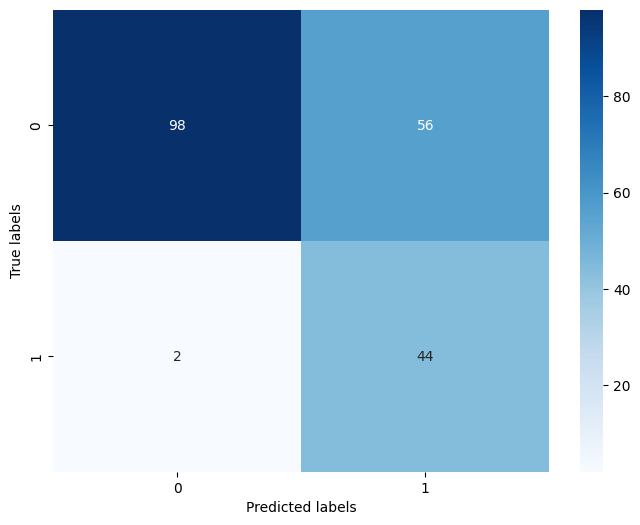

In [32]:
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns
val_path = './pics1_imglabel_datasets/val'
ploting(valid_loader, model,val_path)

Predicted class: 1
Predicted scores: tensor([[2.6212e-07, 1.0000e+00]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
Gradients computed


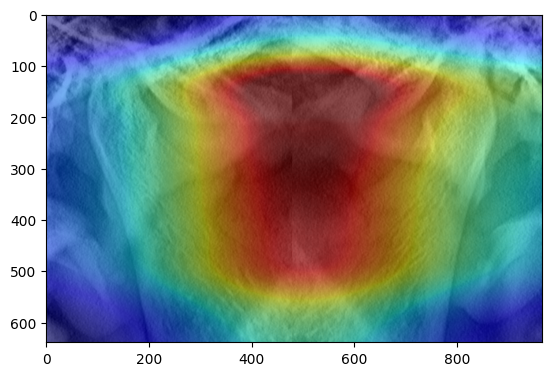

In [42]:
import torch
import torch.nn.functional as F
from torchvision import models, transforms
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

# 加载预训练的 VGG16 模型
pthfile = './vgg16_2/Model_epoch_0.75.pth'
model = torch.load(pthfile)
device = 'cuda'
model.to(device)
model.eval()

# 准备输入图像的变换
preprocess = transforms.Compose([
    transforms.Resize((256, 128)),
    transforms.ToTensor(),
])
# preprocess = A.Compose([
#     A.HorizontalFlip(p=0.5),  #水平翻转
#     # A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0, rotate_limit=15, p=0.5),   # 平移、缩放和旋转
#     ToTensorV2()
# #     A.Sharpen(alpha=(0.2, 0.5), lightness=(0.5, 1.0), p=0.5),  # 锐化操作
# #     A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2, p=0.5),    # 颜色抖动
# #     A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
# ])

# 加载图像并应用变换
img_path = './pics1_imglabel_datasets/val/yes/101_髁突形态基本正常_髁突基本对称_下颌升支基本对称_周海红.jpg'
img = Image.open(img_path).convert('RGB')
img_tensor = preprocess(img).unsqueeze(0).to(device)

# 确保输入图像的梯度被计算
img_tensor.requires_grad = True

# 获取最后一个卷积层的输出
def hook_feature(module, input, output):
    global feature
    feature = output
    feature.retain_grad()  # 保留 feature 张量的梯度


# 注册钩子
hook = model.layer4[-1].register_forward_hook(hook_feature)

# 前向传播
output = model(img_tensor)

# 获取预测分数和类别
pred_scores = F.softmax(output, dim=1)
pred_class = pred_scores.argmax(dim=1).item()

print(f"Predicted class: {pred_class}")
print(f"Predicted scores: {pred_scores}")

# 反向传播获取梯度
model.zero_grad()
one_hot_output = torch.zeros((1, output.size()[-1]), dtype=torch.float32, device=output.device)
one_hot_output[0][pred_class] = 2
output.backward(gradient=one_hot_output, retain_graph=True)

# 检查特征图是否正确计算了梯度
if feature is None:
    print("Feature is None. Ensure hook function is correctly set.")
elif feature.grad is None:
    print("Feature gradients are None. Ensure backward pass is done correctly.")
else:
    gradients = feature.grad[0]
    print("Gradients computed")

    # 计算权重
    weights = torch.mean(gradients, dim=[1, 2], keepdim=True)
    cam = torch.sum(weights * feature[0], dim=0)

    # 将 CAM 标准化
    cam = F.relu(cam)
    cam = cam - cam.min()
    cam = cam / cam.max()

    # 将 CAM 调整到输入图像的尺寸
    cam = cam.detach().cpu().numpy()
    cam = np.uint8(255 * cam)
    cam = Image.fromarray(cam).resize(img.size, Image.LANCZOS)
    cam = np.array(cam)

    # 可视化热力图
    fig, ax = plt.subplots()
    ax.imshow(img)
    ax.imshow(cam, cmap='jet', alpha=0.5)
    plt.show()


In [35]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 